# Capstone Project - A Reasonable Location for a New Bookstore in Greater Melbourne

The codes for the project are divided into several parts to fulfill different functions and support the project.

## Part 1, Data Collection - Melbourne

### 1.1 Extract Data from webpage

The codes in Part 1 were to:
1. Scrape the Wikipedia page, [Local government areas of Victoria](https://en.wikipedia.org/wiki/Local_government_areas_of_Victoria).
2. Extract the data of all local government areas  (LGAs) of Melbourne, including land area and poulation
3. Perform a simple clustering using geo-data
4. Save the dataframe in a csv file for future study

#### Import modules

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes 

from bs4 import BeautifulSoup
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np


#### Import data using url provided

In [2]:
url='https://en.wikipedia.org/wiki/Local_government_areas_of_Victoria'
url_text=requests.get(url).text
url_text


'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Local government areas of Victoria - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"20162917-d741-4146-aa48-b107c88ccd8c","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Local_government_areas_of_Victoria","wgTitle":"Local government areas of Victoria","wgCurRevisionId":967835741,"wgRevisionId":967835741,"wgArticleId":140283,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["EngvarB from August 2014","Use dmy dates from August 2014","Articles with hCards","Local government a

#### Using BeautifulSoup to process url_text

In [3]:
url_text_bs = BeautifulSoup(url_text, 'html.parser')
# url_text_bs


#### Creat a new Dataframe

In [4]:
column_names = ['LocalGovernmentArea','CouncilSeat','Region','LandArea','Population']
df_city = pd.DataFrame(columns = column_names)


#### Extract the first table

In [5]:
content = url_text_bs.find('div', class_='mw-parser-output')
table = content.table.tbody


As shown in the following screeshot, the table includes more data than I needed. During extraction process, all the columns were extracted, but certain columns were not inserted into the final dataframe, such as "Land Area in sq mi" and "Population 2013".
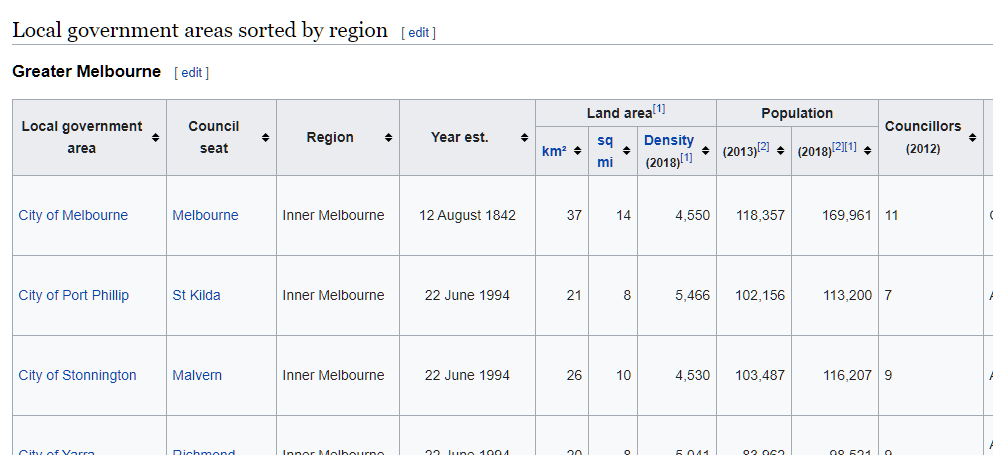

#### Process the table to extract useful data

In [6]:
# default values
LocalGovernmentArea = 'Not assigned'
CouncilSeat = 'Not assigned'
Region = 'Not assigned'
Date = 'Not assigned'
LandAreaKM2 = 'Not assigned'
LandAreaSQM = 'Not assigned'
Population13 = 'Not assigned'
Population18 = 'Not assigned'

# extract the table content and assigne into the dataframe
for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        # print(i,':',td)
        if i == 0:
            LocalGovernmentArea = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            CouncilSeat = td.text.strip('\n')
            i = i + 1
        elif i == 2: 
            Region = td.text.strip('\n')
            i= i + 1
        elif i == 3:
            Data = td.text.strip('\n')
            i= i + 1
        elif i == 4:
            LandAreaKM2 = td.text.strip('\n')
            i= i + 1
        elif i == 5:
            LandAreainSQM = td.text.strip('\n')
            i = i + 1
        elif i == 6:
            LandAreainDensity = td.text.strip('\n')
            i = i + 1
        elif i == 7:
            Population13 = td.text.strip('\n')
            i = i + 1
        elif i == 8:
            Population18 = td.text.strip('\n')
            i = i + 1
    #print(i,':',LocalGovernmentArea,' ',CouncilSeat,' ',Region,' ',LandAreaKM2,' ',Population18)  
    df_city = df_city.append(
        {'LocalGovernmentArea': LocalGovernmentArea,
         'CouncilSeat': CouncilSeat,
         'Region': Region, 
         'LandArea':LandAreaKM2, 
         'Population':Population18},
        ignore_index=True)


#### Further process the dataframe

In [7]:
# drop the "empty" row
df_city = df_city[df_city.LocalGovernmentArea!='Not assigned']
df_city.reset_index(drop = True, inplace = True)

# convert data into correct type
df_city['LandArea'] = df_city['LandArea'].str.replace(',', '').astype(float)
df_city['Population'] = df_city['Population'].str.replace(',', '').astype(int)

df_city.head()


,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population
0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961
1,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200
2,City of Stonnington,Malvern,Inner Melbourne,26.0,116207
3,City of Yarra,Richmond,Inner Melbourne,20.0,98521
4,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237


### 1.2 Plot population data on the map with a simple clustering

#### Obtain LGA as a new dataframe

In [8]:
df_LGA = list(df_city['CouncilSeat'])
l=len(df_LGA)


#### Use nominatim, geolocator to obtain latitude and longtitude of each LGA

In [9]:
latitudes = []
longitudes = []

for i in range(l):
    local = df_LGA[i]
    address = local + ', Victoria, Australia'
    print(address)
    geolocator = Nominatim(user_agent='Melboure_Exp')
    location=geolocator.geocode(address)
    lat=location.latitude
    long=location.longitude
    latitudes.append(lat)
    longitudes.append(long)

print(latitudes)
print(longitudes)


Melbourne, Victoria, Australia
St Kilda, Victoria, Australia
Malvern, Victoria, Australia
Richmond, Victoria, Australia
Greensborough, Victoria, Australia
Sandringham, Victoria, Australia
Camberwell, Victoria, Australia
Preston, Victoria, Australia
Caulfield North, Victoria, Australia
Altona, Victoria, Australia
Cheltenham, Victoria, Australia
Doncaster, Victoria, Australia
Footscray, Victoria, Australia
Glen Waverley, Victoria, Australia
Moonee Ponds, Victoria, Australia
Coburg, Victoria, Australia
Nunawading, Victoria, Australia
Sunshine, Victoria, Australia
Officer, Victoria, Australia
Narre Warren, Victoria, Australia
Frankston, Victoria, Australia
Dandenong, Victoria, Australia
Broadmeadows, Victoria, Australia
Wantirna South, Victoria, Australia
Ringwood East, Victoria, Australia
Melton, Victoria, Australia
Rosebud, Victoria, Australia
Greensborough, Victoria, Australia
South Morang, Victoria, Australia
Werribee, Victoria, Australia
Lilydale, Victoria, Australia
[-37.8142176, -37

#### Insert latitude and longitude into the original dataframe

In [10]:
df_city.insert(loc=5,column='Latitude',value=latitudes)
df_city.insert(loc=6,column='Longitude',value=longitudes)


#### Save the dataframe into a csv file for future study

In [11]:
df_city.to_csv("city_melbourne.csv",index=False)
df_city.info()
df_city.describe()
df_city.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LocalGovernmentArea  31 non-null     object 
 1   CouncilSeat          31 non-null     object 
 2   Region               31 non-null     object 
 3   LandArea             31 non-null     float64
 4   Population           31 non-null     int32  
 5   Latitude             31 non-null     float64
 6   Longitude            31 non-null     float64
dtypes: float64(3), int32(1), object(3)
memory usage: 1.7+ KB


,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population,Latitude,Longitude
0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961,-37.814218,144.963161
1,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200,-37.863826,144.981637
2,City of Stonnington,Malvern,Inner Melbourne,26.0,116207,-37.857609,145.035067
3,City of Yarra,Richmond,Inner Melbourne,20.0,98521,-37.820395,145.002515
4,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237,-37.704028,145.108216


#### Clustering LGAs of Greater Melbourne into 6 regions based on the distance between them

In [12]:
k=6

df_clustering = df_city.drop(['LocalGovernmentArea','CouncilSeat','Region','LandArea','Population'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(df_clustering)
#print(kmeans.labels_)
df_city_clustering=df_city.copy(deep=True)
df_city_clustering.insert(0, 'ClusterLabels', kmeans.labels_)

print('The shape is ',df_city_clustering.shape)
#df.to_csv("city_melbourne_clustering_6.csv",index=False)
df_city_clustering.head()

The shape is  (31, 8)


,ClusterLabels,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population,Latitude,Longitude
0,0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961,-37.814218,144.963161
1,5,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200,-37.863826,144.981637
2,5,City of Stonnington,Malvern,Inner Melbourne,26.0,116207,-37.857609,145.035067
3,5,City of Yarra,Richmond,Inner Melbourne,20.0,98521,-37.820395,145.002515
4,2,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237,-37.704028,145.108216


#### Plot all LGA polulations on the map

In [13]:
# create map
latitude = df_city_clustering.loc[0,'Latitude']
longitude = df_city_clustering.loc[0,'Longitude']

map_clusters = folium.Map(location=[latitude,longitude],zoom_start=9)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, councilseat, population, cluster in zip(df_city_clustering['Latitude'], df_city_clustering['Longitude'], df_city_clustering['CouncilSeat'], df_city_clustering['Population'], df_city_clustering['ClusterLabels']):
    label = '{}'.format(councilseat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20*population/350000,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters